# RAG Agent (part 2)

We got to point 4 of our checlist:

**1. get a knowledge base: we do that manually, and for this example we use only one document for simplicity.** 

**2. perform OCR of our documents to best extract information;**

**3. embed our documents in a vector database (vector store)**

**4. construct a tool for searching in the database** *<-- we are here* 

**5. create the graph.** 

The idea now is that we could make a single RAG agent with tools, but actually (for the love of the game) we will constructa more robust graph system, drawing inspiration from this LangChain tutorial : [link](https://docs.langchain.com/oss/python/langgraph/agentic-rag#overview).

We will construct a graph that after retrieval checks the relevance of the retrieved documents (grading) and if nothing relevant is found rewrites the query and tries again.

<center>
    <img src="./images/rag.png" width=900>
</center>

We will do this ^ but in a more modern (LangGraph >= 1.0) way.

Let's start by constructing our tool:

## 4. Constructing a Retriever Tool

This is super simple once we already created (see pt. 1) our vector store:

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import os

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")  # embeddings have to match!

chroma_dir = "RAG/chroma"

if not os.path.exists(chroma_dir):
    raise ValueError(f"Vector store with name {chroma_dir} does not exists!")

vector_store = Chroma(
    embedding_function=embedding_function,
    persist_directory=chroma_dir
)

print(vector_store._collection.count())

111


Now we want to construct our graph. Our idea is the following:

<center>
<img src="./images/rag_final.png" width=400>
</center>
So basically we want to have a router that will either answer the user or route to the actual RAG, if additional context is needed. 

Also, the RAG agent will have its retrieved context graded, and if it passes the grading we generate the answer for the user: otherwise the query is rewritten (max 3 re-routings).

In order to do this we need a custom state first:

In [2]:
from langchain.agents import AgentState
from typing import Annotated

def add_counter(left : int | None, right: int | None) -> int:
    """
    Adds right to left.
    """
    if left is None:
        left = 0
    if right is None:
        right = 0
    return left + right

def list_replace(left : list | None, right : list | None) -> list:
    """
    Replaces left list with right list.
    """
    if left is None:
        return []
    if right is None:
        return []

    return right

class MyState(AgentState):
    # will hold the metadata of the last retrieved documents 
    last_retrieved_docs : Annotated[list, list_replace]
    reroute_count : Annotated[int, add_counter]

In [3]:
from langchain_core.messages import ToolMessage
from langchain.tools import tool, ToolRuntime
from langgraph.types import Command

@tool
def retrieve_context(runtime: ToolRuntime, query: str) -> Command:
    """Retrieve information to help answer a query."""
    docs = vector_store.similarity_search(query, k=3)

    if len(docs) == 0:
        raise RuntimeError("No documents found")

    serialized = "\n\n".join(
        (f"Source: {doc.metadata['source']}, Page: {doc.metadata['global_page_number']}\nContent: {doc.page_content}")
        for doc in docs
    )

    # add retrieved metadata to state in order to show it to the user later
    last_retrieved_docs = [
        {
            'doc_id': doc.metadata['doc_id'],
            'metadata': doc.metadata,
            'content': doc.page_content
        }
        for doc in docs
    ]

    return Command(
        update={
            "messages" : [ToolMessage(content=serialized, tool_call_id=runtime.tool_call_id)],
            "last_retrieved_docs" : last_retrieved_docs
        }
    )

## 5. Create the Graph

first we create a `generate_query_or_respond` node. 

It's a simple llm that decides wwether the answer can be actually answered by retriving context or instead if it's a general answer that doesn't need context retrieval.

In [ ]:
from langchain.agents import create_agent, AgentState
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from typing import Literal

class RouterResponse(BaseModel):
    message: str = Field(description="The message to either be displayed to the user or to be displayed to the retriever agent")
    next: str = Field(description="The name of the node to call next: can be one of `retrieve_context` (if the answer needs context retrieval) or 'END' if the answer does not reguard the paper.")

router_llm = ChatOpenAI(model="gpt-4o")
router_agent = create_agent(
    model=router_llm,
    tools=[],
    response_format=RouterResponse,
    system_prompt="""
    You are a helpful assistant that, given a user question, decides wether the answer can be answered by retriving context
    or instead if it's a general answer that doesn't need context retrieval.

    The context that can be retrieved is limited to the scientific paper about the Kimi K2 model from Moonshot AI.
    There is no other context available.

    You answer is composed of two fields:
    - `message`: the message to either be displayed to the user or to be displayed to the retriever agent
    - `next`: the name of the node to call next: can be one of `retrieve` (if the answer needs context retrieval about Kimi K2) or 'END' if the answer does not reguard the paper.
    
    The message to the retriever agent can simply be a concise routing message.
    """
)

def generate_query_or_respond(state: MyState) -> Command[Literal['rag_agent', '__end__']]:
    """
    Decides wether the answer can be actually answered by retriving context or instead if it's a general answer that doesn't need context retrieval.
    """
    response = router_agent.invoke(state)
    structured_response = response['structured_response']

    # routing
    next = structured_response.next
    if next == 'retrieve':
        goto = 'rag_agent'
    else:
        goto = '__end__'

    message = structured_response.message

    return Command(
        update={
            "messages" : [HumanMessage(content=message)]
        },
        goto=goto
    )


This is a just a call to an llm that is given the above tool.

In [47]:
from langchain_core.messages import HumanMessage

retriever_agent = create_agent(
    model=ChatOpenAI(model="gpt-4o"),
    tools=[retrieve_context],
    system_prompt="""
    You are a helpful assistant that can answer questions about a scientific paper, 
    which regards the implementation of the Kimi K2 model from Moonshot AI.
    You can use the retriever tool to retrieve information from the paper.

    If not alredy included, add the keywords 'img' and 'table' in the query in order to faciliate the retrieval of images and tables.
    """,
    state_schema=MyState
)

def rag_agent(state: MyState)-> Command[Literal['grade_documents']]:
    """
    Invokes the retriever agent.
    """
    response = retriever_agent.invoke(state)
    # parse out last message and last docs
    last_msg = response['messages'][-1]
    last_retrieved_docs = response['last_retrieved_docs']

    return Command(
        update={
            "messages": [HumanMessage(content=last_msg.content)],
            "last_retrieved_docs" : last_retrieved_docs
        },
        goto='grade_documents'
    )

Add a conditional edge — `grade_documents` — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema `GradeDocuments` for document grading. The `grade_documents` function will return the name of the node to go to based on the grading decision (`generate_answer` or `rewrite_question`):

In [48]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.chat_models import init_chat_model

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

grader_model = init_chat_model("gpt-4o", temperature=0)

def grade_documents(
    state: MyState,
) -> Command[Literal["generate_answer", "rewrite_question"]]:

    """Determine whether the retrieved documents are relevant to the question."""

    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        goto = "generate_answer"
        reroute = 0  # going to generate answer
        last_retrieved_docs = state['last_retrieved_docs']  # do not reset

    else:
        goto = "rewrite_question"
        reroute = 1  # +1 reroute
        last_retrieved_docs = []  # reset documents, we are retrieving again
        
    return Command(
        update={
            "reroute_count" : reroute,
            "last_retrieved_docs" : last_retrieved_docs
        },
        goto=goto
    )

and now we build the `rewrite_question` node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the `rewrite_question` node:

In [49]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

response_model = init_chat_model("gpt-4o", temperature=0)

def rewrite_question(state: MyState)-> Command[Literal['rag_agent', '__end__']]:
    """Rewrite the original user question."""

    # check the number of reroutings
    if state['reroute_count'] >= 3:
        return Command(
            update={
                "messages" : [HumanMessage(content="Number of maximum retires exceeded, ending flow")]
            },
            goto='__end__'
        )

    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return Command(
        update={
            "messages": [HumanMessage(content=response.content)]
        },
        goto='rag_agent'
    )

finally, the `generate_answer` node: if we pass the grader checks, we can generate the final answer based on the original question and the retrieved context.

We also show the corresponding page and metadata to the user, which is always nice. In order to do so we need a funciton that re-inserts the images and tables in the text

In [50]:
import json

GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Question: {question} \n"
    "Context: {context}"
)

def generate_answer(state: MyState)-> Command[Literal['__end__']]:
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])

    last_retrieved_docs = state.get('last_retrieved_docs', [])

    return Command(
        update={
            "messages": [response],
            "last_retrieved_docs" : last_retrieved_docs
        },
        goto='__end__'
    )

Now we build the graph:

In [51]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

workflow = StateGraph(MyState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node(rag_agent)
workflow.add_node(grade_documents)
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Compile
graph = workflow.compile(checkpointer=checkpointer)

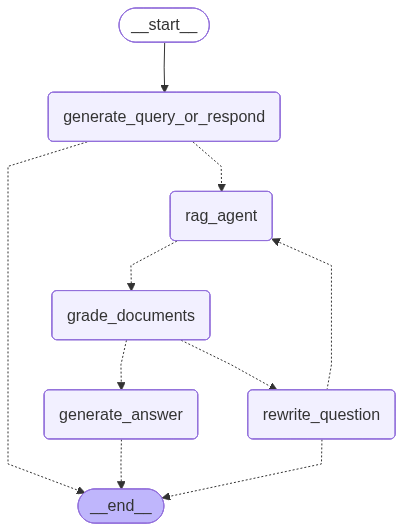

In [52]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
import uuid

input_msg = HumanMessage("What are the differences between KimiK2 and other models?")

input_state = {"messages" : [input_msg]}
config = {"configurable": {"thread_id": str(uuid.uuid4()), "recursion_limit": 50}}

for chunk in graph.stream(input_state, config, stream_mode="updates"):
    for node_name, values in chunk.items():
        if 'messages' in values:
            values['messages'][-1].pretty_print()

================================ Human Message =================================

Retrieve context about the differences between the Kimi K2 model and other models from the scientific paper.
================================ Human Message =================================

The Kimi K2 model differentiates itself from other models in several ways:

1. **Model Architecture:**
   - Kimi K2 is a Mixture-of-Experts (MoE) transformer model with 1.04 trillion parameters and 32 billion activated parameters. This is in contrast to similar architectures like DeepSeek-V3, which have fewer experts and attention heads (256 experts and 128 attention heads compared to Kimi K2's 384 experts and 64 attention heads). This design decision was made to enhance performance while reducing computational overhead.
   - The model utilizes Multi-head Latent Attention as its attention mechanism, with a hidden dimension of 7168 and an MoE expert hidden dimension of 2048. The choice to increase the sparsity and thus

In [54]:
state_snapshot = graph.get_state(config)

In [55]:
from IPython.display import display, Markdown

def reinsert_images_and_tables(text: str, heavy_metadata: dict) -> str:
    """Reinsert images and tables by replacing placeholders."""
    
    # Replace image placeholders
    for img in heavy_metadata.get('images', []):
        img_id = img['id']
        placeholder = f"![{img_id}](PLACEHOLDER_{img_id})"
        base64_data = img['base64']  # Already has data:image/jpeg;base64,... prefix
        replacement = f"![{img_id}]({base64_data})"  # Use directly
        text = text.replace(placeholder, replacement)
    
    # Replace table placeholders  
    for tbl in heavy_metadata.get('tables', []):
        tbl_id = tbl['id']
        placeholder = f"[{tbl_id}](PLACEHOLDER_{tbl_id})"
        replacement = f"\n\n{tbl['html_content']}\n\n"
        text = text.replace(placeholder, replacement)
    
    return text

def display_results(messages, last_retrieved_docs, heavy_metadata_path='RAG/OCR/heavy_metadata.json'):
    """Display LLM answer and retrieved documents with images/tables."""
    
    # Load and enhance docs
    with open(heavy_metadata_path, 'r') as f:
        heavy_metadata = json.load(f)
    
    doc_ids = [doc['doc_id'] for doc in last_retrieved_docs]
    heavy_metadata_for_docs = [h for h in heavy_metadata if h['doc_id'] in doc_ids]
    
    for doc in last_retrieved_docs:
        heavy_meta = next((h for h in heavy_metadata_for_docs if h['doc_id'] == doc['doc_id']), None)
        if heavy_meta:
            doc['enhanced_content'] = reinsert_images_and_tables(doc['content'], heavy_meta)
        else:
            doc['enhanced_content'] = doc['content']
    
    # Display
    display(Markdown(messages[-1].content))
    
    if last_retrieved_docs:
        display(Markdown("---"))
        display(Markdown("## Retrieved Documents"))
        
        for i, doc in enumerate(last_retrieved_docs, 1):
            page_num = doc['metadata'].get('global_page_number', 'N/A')
            source = doc['metadata'].get('source', 'Unknown')
            
            display(Markdown(f"### Document {i}"))
            display(Markdown(f"**Source:** `{source}` | **Page:** {page_num}"))
            display(Markdown(doc['enhanced_content']))
            display(Markdown("---"))
    else:
        display(Markdown("*No documents retrieved*"))

In [56]:
# Load heavy metadata once
with open('RAG/OCR/heavy_metadata.json', 'r') as f:
    heavy_metadata = json.load(f)

# Get retrieved docs from final state
last_retrieved_docs = state_snapshot.values['last_retrieved_docs']
messages = state_snapshot.values['messages']

# Display results
display_results(messages, last_retrieved_docs)

The Kimi K2 model differentiates itself from other models in several key ways:

1. **Model Architecture:**
   - Kimi K2 is a Mixture-of-Experts (MoE) transformer model with 1.04 trillion parameters and 32 billion activated parameters. It has more experts (384) and fewer attention heads (64) compared to models like DeepSeek-V3, which has 256 experts and 128 attention heads. This architecture is designed to enhance performance while reducing computational overhead.
   - It uses Multi-head Latent Attention with a hidden dimension of 7168 and an MoE expert hidden dimension of 2048. The model's increased sparsity and number of experts are based on scaling law analysis for performance improvements.

2. **Performance:**
   - Kimi K2 shows state-of-the-art performance among open-source non-thinking models, excelling in agentic capabilities and outperforming many open and closed-source models in various benchmarks.
   - It surpasses most baseline models on benchmarks like Tau2-Bench, ACEBench, SWE-Bench Verified, and SWE-Bench Multilingual, and performs strongly in coding, mathematics, and reasoning tasks.

3. **Release and Accessibility:**
   - Kimi K2 is noted as one of the most capable open-source large language models, particularly for software engineering and agentic tasks. The release of its base and post-trained model checkpoints is intended to support further research and application in agentic intelligence.

These differences highlight Kimi K2's architectural innovations, superior performance, and accessibility compared to other models.

---

## Retrieved Documents

### Document 1

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 15

Table 3: Performance comparison of Kimi-K2-Instruct against leading open-source and proprietary models across diverse tasks. Bold denotes the global SOTA; underlined bold indicates the best open-source result. Data points marked with * are taken directly from the model's technical report or blog.



<table><tr><td rowspan="2">Benchmark</td><td colspan="3">Open Source</td><td colspan="4">Proprietary</td></tr><tr><td>Kimi-K2-Instruct</td><td>DeepSeek-V3-0324</td><td>Qwen3-235B-A22B</td><td>Claude Sonnet 4</td><td>Claude Opus 4</td><td>GPT-4.1</td><td>Gemini 2.5 Flash</td></tr><tr><td colspan="8">Coding Tasks</td></tr><tr><td>LiveCodeBench v6 (Pass@1)</td><td>53.7</td><td>46.9</td><td>37.0</td><td>48.5</td><td>47.4</td><td>44.7</td><td>44.7</td></tr><tr><td>OJBench (Pass@1)</td><td>27.1</td><td>24.0</td><td>11.3</td><td>15.3</td><td>19.6</td><td>19.5</td><td>19.5</td></tr><tr><td>MultiPL-E (Pass@1)</td><td>85.7</td><td>83.1</td><td>78.2</td><td>88.6</td><td>89.6</td><td>86.7</td><td>85.6</td></tr><tr><td>SWE-bench Verified</td><td>51.8</td><td>36.6</td><td>39.4</td><td>50.2</td><td>53.0</td><td>40.8</td><td>32.6</td></tr><tr><td>Agentless-Single-Patch (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Verified</td><td>65.8</td><td>38.8</td><td>34.4</td><td>72.7*</td><td>72.5*</td><td>54.6</td><td>—</td></tr><tr><td>Agentic-Single-Attempt (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Verified</td><td>71.6</td><td>—</td><td>—</td><td>80.2*</td><td>79.4*</td><td>—</td><td>—</td></tr><tr><td>Agentic-Multi-Attempt (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Multilingual (Pass@1)</td><td>47.3</td><td>25.8</td><td>20.9</td><td>51.0</td><td>—</td><td>31.5</td><td>—</td></tr><tr><td>Multi-SWE-bench (Pass@1)</td><td>18.3</td><td>8.0</td><td>9.0</td><td>29.2</td><td>—</td><td>11.7</td><td>14.0</td></tr><tr><td>SWE-Lancer (Pass@1)</td><td>39.1</td><td>30.5</td><td>24.1</td><td>40.8</td><td>—</td><td>23.0</td><td>38.5</td></tr><tr><td>Paper Bench Code-Dev (Acc.)</td><td>27.8</td><td>12.2</td><td>13.2</td><td>43.3</td><td>—</td><td>29.9</td><td>5.7</td></tr><tr><td>Terminal Bench In-House (Acc.)</td><td>30.0</td><td>—</td><td>—</td><td>35.5</td><td>43.2</td><td>8.3</td><td>—</td></tr><tr><td>Terminal Bench Terminus (Acc.)</td><td>25.0</td><td>16.3</td><td>6.6</td><td>—</td><td>—</td><td>30.3</td><td>16.8</td></tr><tr><td>Aider-Polyglot (Acc.)</td><td>60.0</td><td>55.1</td><td>61.8</td><td>56.4</td><td>70.7</td><td>52.4</td><td>44.0</td></tr><tr><td colspan="8">Tool Use Tasks</td></tr><tr><td>Tau2 retail (Avg@4)</td><td>70.6</td><td>69.1</td><td>57.0</td><td>75.0</td><td>81.8</td><td>74.8</td><td>64.3</td></tr><tr><td>Tau2 airline (Avg@4)</td><td>56.5</td><td>39.0</td><td>26.5</td><td>55.5</td><td>60.0</td><td>54.5</td><td>42.5</td></tr><tr><td>Tau2 telecom (Avg@4)</td><td>65.8</td><td>32.5</td><td>22.1</td><td>45.2</td><td>57.0</td><td>38.6</td><td>16.9</td></tr><tr><td>AceBench (Acc.)</td><td>76.5</td><td>72.7</td><td>70.5</td><td>76.2</td><td>75.6</td><td>80.1</td><td>74.5</td></tr><tr><td colspan="8">Math &amp; STEM Tasks</td></tr><tr><td>AIME 2024 (Avg@64)</td><td>69.6</td><td>59.4*</td><td>40.1*</td><td>43.4</td><td>48.2</td><td>46.5</td><td>61.3</td></tr><tr><td>AIME 2025 (Avg@64)</td><td>49.5</td><td>46.7</td><td>24.7*</td><td>33.1*</td><td>33.9*</td><td>37.0</td><td>46.6</td></tr><tr><td>MATH-500 (Acc.)</td><td>97.4</td><td>94.0*</td><td>91.2*</td><td>94.0</td><td>94.4</td><td>92.4</td><td>95.4</td></tr><tr><td>HMMT 2025 (Avg@32)</td><td>38.8</td><td>27.5</td><td>11.9</td><td>15.9</td><td>15.9</td><td>19.4</td><td>34.7</td></tr><tr><td>CNMO 2024 (Avg@16)</td><td>74.3</td><td>74.7</td><td>48.6</td><td>60.4</td><td>57.6</td><td>56.6</td><td>75.0</td></tr><tr><td>PolyMath-en (Avg@4)</td><td>65.1</td><td>59.5</td><td>51.9</td><td>52.8</td><td>49.8</td><td>54.0</td><td>49.9</td></tr><tr><td>ZebraLogic (Acc.)</td><td>89.0</td><td>84.0</td><td>37.7*</td><td>79.7</td><td>59.3</td><td>58.5</td><td>57.9</td></tr><tr><td>AutoLogi (Acc.)</td><td>89.5</td><td>88.9</td><td>83.3*</td><td>89.8</td><td>86.1</td><td>88.2</td><td>84.1</td></tr><tr><td>GPQA-Diamond (Avg@8)</td><td>75.1</td><td>68.4*</td><td>62.9*</td><td>70.0*</td><td>74.9*</td><td>66.3</td><td>68.2</td></tr><tr><td>SuperGPQA (Acc.)</td><td>57.2</td><td>53.7</td><td>50.2</td><td>55.7</td><td>56.5</td><td>50.8</td><td>49.6</td></tr><tr><td>Humanity's Last Exam (Acc.)</td><td>4.7</td><td>5.2</td><td>5.7</td><td>5.8</td><td>7.1</td><td>3.7</td><td>5.6</td></tr><tr><td colspan="8">General Tasks</td></tr><tr><td>MMLU (EM)</td><td>89.5</td><td>89.4</td><td>87.0</td><td>91.5</td><td>92.9</td><td>90.4</td><td>90.1</td></tr><tr><td>MMLU-Redux (EM)</td><td>92.7</td><td>90.5</td><td>89.2*</td><td>93.6</td><td>94.2</td><td>92.4</td><td>90.6</td></tr><tr><td>MMLU-Pro (EM)</td><td>81.1</td><td>81.2*</td><td>77.3</td><td>83.7</td><td>86.6</td><td>81.8</td><td>79.4</td></tr><tr><td>IFEval (Prompt Strict)</td><td>89.8</td><td>81.1</td><td>83.2*</td><td>87.6</td><td>87.4</td><td>88.0</td><td>84.3</td></tr><tr><td>Multi-Challenge (Acc.)</td><td>54.1</td><td>31.4</td><td>34.0</td><td>46.8</td><td>49.0</td><td>36.4</td><td>39.5</td></tr><tr><td>SimpleQA (Correct)</td><td>31.0</td><td>27.7</td><td>13.2</td><td>15.9</td><td>22.8</td><td>42.3</td><td>23.3</td></tr><tr><td>Livebench (Pass@1)</td><td>76.4</td><td>72.4</td><td>67.6</td><td>74.8</td><td>74.6</td><td>69.8</td><td>67.8</td></tr><tr><td>Arena Hard v2.0</td><td>54.5</td><td>39.9</td><td>39.9</td><td>51.6</td><td>59.7</td><td>51.7</td><td>48.7</td></tr><tr><td>Hard Prompt (Win rate)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>Arena Hard v2.0</td><td>85.0</td><td>59.3</td><td>59.8</td><td>54.6</td><td>68.5</td><td>61.5</td><td>72.8</td></tr><tr><td>Creative Writing (Win rate)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>FACTS Grounding (Adjusted)</td><td>88.5</td><td>68.3</td><td>68.5</td><td>83.6</td><td>—</td><td>79.2</td><td>86.6</td></tr><tr><td>HHEM v2.1 (1-Hallu.)</td><td>98.9</td><td>88.9</td><td>94.5</td><td>94.5</td><td>—</td><td>96.7</td><td>97.8</td></tr><tr><td>FaithJudge (1-Hallu.)</td><td>92.6</td><td>83.4</td><td>75.7</td><td>83.0</td><td>—</td><td>91.0</td><td>93.2</td></tr><tr><td>LongBench v2 (Acc.)</td><td>49.1</td><td>51.1</td><td>—</td><td>52.5</td><td>—</td><td>54.3</td><td>55.5</td></tr><tr><td>FRAMES (Acc.)</td><td>77.1</td><td>79.2</td><td>—</td><td>76.3</td><td>—</td><td>87.4</td><td>72.9</td></tr><tr><td>MRCR (Acc.)</td><td>55.0</td><td>50.8</td><td>—</td><td>74.4</td><td>—</td><td>66.9</td><td>81.7</td></tr><tr><td>DROP (Acc.)</td><td>93.5</td><td>91.2</td><td>84.3</td><td>92.0</td><td>—</td><td>79.1</td><td>81.7</td></tr></table>



---

### Document 2

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 5

# 2.3 Model Architecture

Kimi K2 is a 1.04 trillion-parameter Mixture-of-Experts (MoE) transformer model with 32 billion activated parameters. The architecture follows a similar design to DeepSeek-V3 [10], employing Multi-head Latent Attention (MLA) [44] as the attention mechanism, with a model hidden dimension of 7168 and an MoE expert hidden dimension of 2048. Our scaling law analysis reveals that continued increases in sparsity yield substantial performance improvements, which motivated us to increase the number of experts to 384, compared to 256 in DeepSeek-V3. To reduce computational overhead during inference, we cut the number of attention heads to 64, as opposed to 128 in DeepSeek-V3. Table 2 presents a detailed comparison of architectural parameters between Kimi K2 and DeepSeek-V3.

Table 2: Architectural comparison between Kimi K2 and DeepSeek-V3



<table><tr><td></td><td>DeepSeek-V3</td><td>Kimi K2</td><td>Δ</td></tr><tr><td>#Layers</td><td>61</td><td>61</td><td>=</td></tr><tr><td>Total Parameters</td><td>671B</td><td>1.04T</td><td>↑54%</td></tr><tr><td>Activated Parameters</td><td>37B</td><td>32.6B</td><td>↓13%</td></tr><tr><td>Experts (total)</td><td>256</td><td>384</td><td>↑50%</td></tr><tr><td>Experts Active per Token</td><td>8</td><td>8</td><td>=</td></tr><tr><td>Shared Experts</td><td>1</td><td>1</td><td>=</td></tr><tr><td>Attention Heads</td><td>128</td><td>64</td><td>↓50%</td></tr><tr><td>Number of Dense Layers</td><td>3</td><td>1</td><td>↓67%</td></tr><tr><td>Expert Grouping</td><td>Yes</td><td>No</td><td>-</td></tr></table>



---

### Document 3

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 0

Kimi K2 achieves state-of-the-art performance among open-source non-thinking models, with strengths in agentic capabilities. Notably, K2 obtains 66.1 on Tau2-Bench, 76.5 on ACEBench (En), 65.8 on SWE-Bench Verified, and 47.3 on SWE-Bench Multilingual — surpassing most open and closed-sourced baselines in non-thinking settings. It also exhibits strong capabilities in coding, mathematics, and reasoning tasks, with a score of 53.7 on LiveCodeBench v6, 49.5 on AIME 2025, 75.1 on GPQA-Diamond, and 27.1 on OJBench, all without extended thinking. These results position Kimi K2 as one of the most capable open-source large language models to date, particularly in software engineering and agentic tasks. We release our base and post-trained model checkpoints $^{1}$  to facilitate future research and applications of agentic intelligence.

---

In [57]:
import uuid

input_msg = HumanMessage("Tell me about parallelism in kimik2")

input_state2 = {"messages" : [input_msg]}
config2 = {"configurable": {"thread_id": str(uuid.uuid4()), "recursion_limit": 50}}

for chunk in graph.stream(input_state2, config2, stream_mode="updates"):
    for node_name, values in chunk.items():
        if 'messages' in values:
            values['messages'][-1].pretty_print()

================================ Human Message =================================

Retrieve context about parallelism in KimiK2 model from the scientific paper.
================================ Human Message =================================

The Kimi K2 model utilizes several types of parallelism to enhance performance:

1. **Pipeline Parallelism (PP):** This involves breaking down a machine learning model into various stages and running these stages in parallel over different devices. A timeline illustration (Figure 7) shows how computational tasks like Attention, Multi-Layer Perceptron, and Error Propagation are managed across different stages, highlighting the forward and backward pass, and PP communication.

   ![Pipeline Parallelism Timeline](PLACEHOLDER_img-7.jpeg)
   
   In this diagram, the process is divided into Computation, Communication, and Offloading tasks, with color codes to distinguish different operations.

2. **Expert Parallelism (EP):** The model implements a 16-way

The Kimi K2 model employs several types of parallelism to enhance its performance:

1. **Pipeline Parallelism (PP):** This method involves dividing the machine learning model into different stages and running these stages in parallel across various devices. It manages computational tasks such as Attention, Multi-Layer Perceptron, and Error Propagation across different stages, focusing on both the forward and backward pass, as well as PP communication.

2. **Expert Parallelism (EP):** The model uses a 16-way expert parallelism strategy, allowing different parts of the model, referred to as "experts," to run simultaneously. This increases throughput and efficiency.

3. **ZeRO-1 Data Parallelism:** This technique splits the model's data across multiple devices, which helps reduce memory usage and speeds up computations.

These parallel processing strategies enable the Kimi K2 model to efficiently handle complex tasks by distributing the workload across various computational resources.

---

## Retrieved Documents

### Document 1

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 15

Table 3: Performance comparison of Kimi-K2-Instruct against leading open-source and proprietary models across diverse tasks. Bold denotes the global SOTA; underlined bold indicates the best open-source result. Data points marked with * are taken directly from the model's technical report or blog.



<table><tr><td rowspan="2">Benchmark</td><td colspan="3">Open Source</td><td colspan="4">Proprietary</td></tr><tr><td>Kimi-K2-Instruct</td><td>DeepSeek-V3-0324</td><td>Qwen3-235B-A22B</td><td>Claude Sonnet 4</td><td>Claude Opus 4</td><td>GPT-4.1</td><td>Gemini 2.5 Flash</td></tr><tr><td colspan="8">Coding Tasks</td></tr><tr><td>LiveCodeBench v6 (Pass@1)</td><td>53.7</td><td>46.9</td><td>37.0</td><td>48.5</td><td>47.4</td><td>44.7</td><td>44.7</td></tr><tr><td>OJBench (Pass@1)</td><td>27.1</td><td>24.0</td><td>11.3</td><td>15.3</td><td>19.6</td><td>19.5</td><td>19.5</td></tr><tr><td>MultiPL-E (Pass@1)</td><td>85.7</td><td>83.1</td><td>78.2</td><td>88.6</td><td>89.6</td><td>86.7</td><td>85.6</td></tr><tr><td>SWE-bench Verified</td><td>51.8</td><td>36.6</td><td>39.4</td><td>50.2</td><td>53.0</td><td>40.8</td><td>32.6</td></tr><tr><td>Agentless-Single-Patch (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Verified</td><td>65.8</td><td>38.8</td><td>34.4</td><td>72.7*</td><td>72.5*</td><td>54.6</td><td>—</td></tr><tr><td>Agentic-Single-Attempt (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Verified</td><td>71.6</td><td>—</td><td>—</td><td>80.2*</td><td>79.4*</td><td>—</td><td>—</td></tr><tr><td>Agentic-Multi-Attempt (Pass@1)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>SWE-bench Multilingual (Pass@1)</td><td>47.3</td><td>25.8</td><td>20.9</td><td>51.0</td><td>—</td><td>31.5</td><td>—</td></tr><tr><td>Multi-SWE-bench (Pass@1)</td><td>18.3</td><td>8.0</td><td>9.0</td><td>29.2</td><td>—</td><td>11.7</td><td>14.0</td></tr><tr><td>SWE-Lancer (Pass@1)</td><td>39.1</td><td>30.5</td><td>24.1</td><td>40.8</td><td>—</td><td>23.0</td><td>38.5</td></tr><tr><td>Paper Bench Code-Dev (Acc.)</td><td>27.8</td><td>12.2</td><td>13.2</td><td>43.3</td><td>—</td><td>29.9</td><td>5.7</td></tr><tr><td>Terminal Bench In-House (Acc.)</td><td>30.0</td><td>—</td><td>—</td><td>35.5</td><td>43.2</td><td>8.3</td><td>—</td></tr><tr><td>Terminal Bench Terminus (Acc.)</td><td>25.0</td><td>16.3</td><td>6.6</td><td>—</td><td>—</td><td>30.3</td><td>16.8</td></tr><tr><td>Aider-Polyglot (Acc.)</td><td>60.0</td><td>55.1</td><td>61.8</td><td>56.4</td><td>70.7</td><td>52.4</td><td>44.0</td></tr><tr><td colspan="8">Tool Use Tasks</td></tr><tr><td>Tau2 retail (Avg@4)</td><td>70.6</td><td>69.1</td><td>57.0</td><td>75.0</td><td>81.8</td><td>74.8</td><td>64.3</td></tr><tr><td>Tau2 airline (Avg@4)</td><td>56.5</td><td>39.0</td><td>26.5</td><td>55.5</td><td>60.0</td><td>54.5</td><td>42.5</td></tr><tr><td>Tau2 telecom (Avg@4)</td><td>65.8</td><td>32.5</td><td>22.1</td><td>45.2</td><td>57.0</td><td>38.6</td><td>16.9</td></tr><tr><td>AceBench (Acc.)</td><td>76.5</td><td>72.7</td><td>70.5</td><td>76.2</td><td>75.6</td><td>80.1</td><td>74.5</td></tr><tr><td colspan="8">Math &amp; STEM Tasks</td></tr><tr><td>AIME 2024 (Avg@64)</td><td>69.6</td><td>59.4*</td><td>40.1*</td><td>43.4</td><td>48.2</td><td>46.5</td><td>61.3</td></tr><tr><td>AIME 2025 (Avg@64)</td><td>49.5</td><td>46.7</td><td>24.7*</td><td>33.1*</td><td>33.9*</td><td>37.0</td><td>46.6</td></tr><tr><td>MATH-500 (Acc.)</td><td>97.4</td><td>94.0*</td><td>91.2*</td><td>94.0</td><td>94.4</td><td>92.4</td><td>95.4</td></tr><tr><td>HMMT 2025 (Avg@32)</td><td>38.8</td><td>27.5</td><td>11.9</td><td>15.9</td><td>15.9</td><td>19.4</td><td>34.7</td></tr><tr><td>CNMO 2024 (Avg@16)</td><td>74.3</td><td>74.7</td><td>48.6</td><td>60.4</td><td>57.6</td><td>56.6</td><td>75.0</td></tr><tr><td>PolyMath-en (Avg@4)</td><td>65.1</td><td>59.5</td><td>51.9</td><td>52.8</td><td>49.8</td><td>54.0</td><td>49.9</td></tr><tr><td>ZebraLogic (Acc.)</td><td>89.0</td><td>84.0</td><td>37.7*</td><td>79.7</td><td>59.3</td><td>58.5</td><td>57.9</td></tr><tr><td>AutoLogi (Acc.)</td><td>89.5</td><td>88.9</td><td>83.3*</td><td>89.8</td><td>86.1</td><td>88.2</td><td>84.1</td></tr><tr><td>GPQA-Diamond (Avg@8)</td><td>75.1</td><td>68.4*</td><td>62.9*</td><td>70.0*</td><td>74.9*</td><td>66.3</td><td>68.2</td></tr><tr><td>SuperGPQA (Acc.)</td><td>57.2</td><td>53.7</td><td>50.2</td><td>55.7</td><td>56.5</td><td>50.8</td><td>49.6</td></tr><tr><td>Humanity's Last Exam (Acc.)</td><td>4.7</td><td>5.2</td><td>5.7</td><td>5.8</td><td>7.1</td><td>3.7</td><td>5.6</td></tr><tr><td colspan="8">General Tasks</td></tr><tr><td>MMLU (EM)</td><td>89.5</td><td>89.4</td><td>87.0</td><td>91.5</td><td>92.9</td><td>90.4</td><td>90.1</td></tr><tr><td>MMLU-Redux (EM)</td><td>92.7</td><td>90.5</td><td>89.2*</td><td>93.6</td><td>94.2</td><td>92.4</td><td>90.6</td></tr><tr><td>MMLU-Pro (EM)</td><td>81.1</td><td>81.2*</td><td>77.3</td><td>83.7</td><td>86.6</td><td>81.8</td><td>79.4</td></tr><tr><td>IFEval (Prompt Strict)</td><td>89.8</td><td>81.1</td><td>83.2*</td><td>87.6</td><td>87.4</td><td>88.0</td><td>84.3</td></tr><tr><td>Multi-Challenge (Acc.)</td><td>54.1</td><td>31.4</td><td>34.0</td><td>46.8</td><td>49.0</td><td>36.4</td><td>39.5</td></tr><tr><td>SimpleQA (Correct)</td><td>31.0</td><td>27.7</td><td>13.2</td><td>15.9</td><td>22.8</td><td>42.3</td><td>23.3</td></tr><tr><td>Livebench (Pass@1)</td><td>76.4</td><td>72.4</td><td>67.6</td><td>74.8</td><td>74.6</td><td>69.8</td><td>67.8</td></tr><tr><td>Arena Hard v2.0</td><td>54.5</td><td>39.9</td><td>39.9</td><td>51.6</td><td>59.7</td><td>51.7</td><td>48.7</td></tr><tr><td>Hard Prompt (Win rate)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>Arena Hard v2.0</td><td>85.0</td><td>59.3</td><td>59.8</td><td>54.6</td><td>68.5</td><td>61.5</td><td>72.8</td></tr><tr><td>Creative Writing (Win rate)</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>FACTS Grounding (Adjusted)</td><td>88.5</td><td>68.3</td><td>68.5</td><td>83.6</td><td>—</td><td>79.2</td><td>86.6</td></tr><tr><td>HHEM v2.1 (1-Hallu.)</td><td>98.9</td><td>88.9</td><td>94.5</td><td>94.5</td><td>—</td><td>96.7</td><td>97.8</td></tr><tr><td>FaithJudge (1-Hallu.)</td><td>92.6</td><td>83.4</td><td>75.7</td><td>83.0</td><td>—</td><td>91.0</td><td>93.2</td></tr><tr><td>LongBench v2 (Acc.)</td><td>49.1</td><td>51.1</td><td>—</td><td>52.5</td><td>—</td><td>54.3</td><td>55.5</td></tr><tr><td>FRAMES (Acc.)</td><td>77.1</td><td>79.2</td><td>—</td><td>76.3</td><td>—</td><td>87.4</td><td>72.9</td></tr><tr><td>MRCR (Acc.)</td><td>55.0</td><td>50.8</td><td>—</td><td>74.4</td><td>—</td><td>66.9</td><td>81.7</td></tr><tr><td>DROP (Acc.)</td><td>93.5</td><td>91.2</td><td>84.3</td><td>92.0</td><td>—</td><td>79.1</td><td>81.7</td></tr></table>



---

### Document 2

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 31

K Kimi K2

TECHNICAL REPORT

As a result, the model may occasionally overstate certainty in areas where ambiguity, nuance, or epistemic modesty would be more appropriate. Future iterations of the framework may incorporate more fine-grained handling of calibrated uncertainty.

# G Engine Switching Pipeline for RL Training

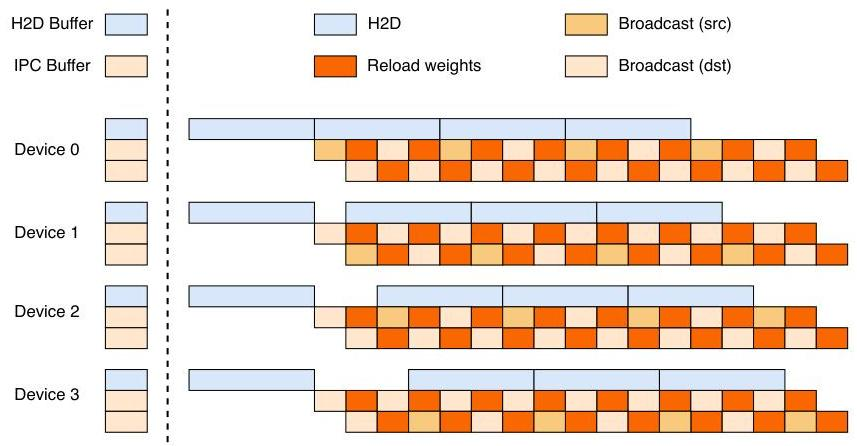
**This image is a Gantt chart that illustrates the scheduling of various operations across four devices. The chart uses different colors to represent different types of operations: H2D Buffer (blue), IPC Buffer (light orange), Reload weights (dark orange), Broadcast (src) (yellow), and Broadcast (dst) (light beige). Each row corresponds to a different device (Device 0 to Device 3), and the horizontal axis represents time. The chart shows the sequence and overlap of these operations, indicating how tasks are managed and synchronized across multiple devices.**
(a) Theoretical perfect three-stage pipeline weight update

---

### Document 3

**Source:** `RAG/OCR/responses_reindexed.json` | **Page:** 7

K Kimi K2

TECHNICAL REPORT

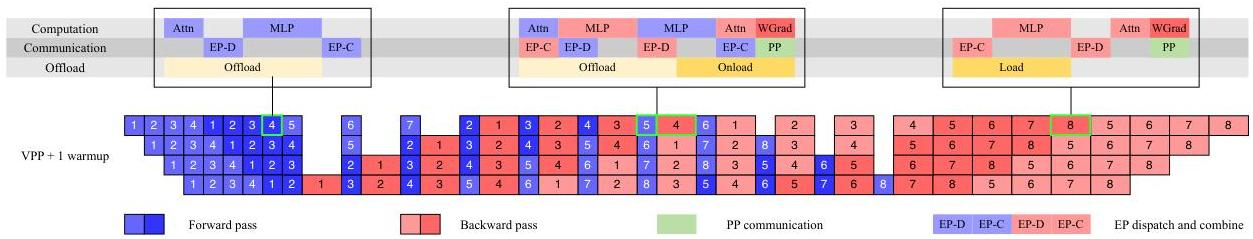
**This image depicts a timeline of computational, communication, and offloading processes in a machine learning pipeline. The timeline is divided into three main categories: Computation, Communication, and Offload. Each category is further divided into specific tasks such as Attention (Attn), Multi-Layer Perceptron (MLP), Error Propagation Dispatch (EP-D), Error Propagation Combine (EP-C), Weight Gradient (WGrad), and Pipeline Parallel (PP). The timeline is segmented into different stages, each marked by a number, indicating the sequence of operations. The color coding helps to distinguish between forward pass (blue), backward pass (red), and PP communication (green). The image also highlights the offloading and loading of tasks, showing how data and computations are managed across different stages.**
Figure 7: Computation, communication and offloading overlapped in different PP phases.

Pipeline Parallelism (PP) with virtual stages [28, 53, 38, 57, 47, 21], 16-way Expert Parallelism (EP) [39], and ZeRO-1 Data Parallelism [60].

---

In [58]:
state_snapshot2 = graph.get_state(config2)

# Get retrieved docs from final state
last_retrieved_docs2 = state_snapshot2.values['last_retrieved_docs']
messages2 = state_snapshot2.values['messages']

# Display results
display_results(messages2, last_retrieved_docs2)